<a href="https://colab.research.google.com/github/karthikpuranik11/Hope-Speech-Detection-/blob/main/Malayalam/xlm_roberta_base%2BbiLSTM_Malayalam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3.3.1

     |████████████████████████████████| 1.1MB 8.8MB/s 
     |████████████████████████████████| 890kB 31.2MB/s 
     |████████████████████████████████| 3.0MB 53.4MB/s 
     |████████████████████████████████| 1.2MB 58.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=f5c70a612138f93155e5618a91e7fe42b04556fc358d2b6b6cf676a0ce132476
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [3]:
train=pd.read_csv('/content/malayalam_hope_train.tsv', header=None, names=['tweets','label'], sep="\t")
train['labels']=LabelEncoder().fit_transform(train['label'])
train=train.drop(columns='label')
train

,tweets,labels
0,@arya s nair may be athile karthikayude charct...,1
1,വാങ്ങിയത് എന്ത് കുന്തം ആയാലും കളയാൻ പറ്റില്ലല്...,1
2,മാറുമറയ്ക്കാൻ നടത്തിയ സമരം ഒരു previlege issue...,0
3,ഇഷാനെ കൂടുതല് കെട്ടിപിടിക്കേണ്ട ഞങ്ങൾക്കറിയാം ...,1
4,ഇന്ത്യ ഇസ്‌ലാമിക രാജ്യമല്ല.. ഇന്ത്യൻ ഭരണഘടന മാ...,0
...,...,...
8559,Evan eatha eee pottan oru vivaravumilla,1
8560,Ithinu pakaramayi upayogikkan pattunna Indian ...,1
8561,സാറിന് നല്ലത് വരട്ടെ,1
8562,ഇങ്ങനത്തെ നല്ല നല്ല അറിവുകൾ പറഞ്ഞു തരുന്ന ഈ ഡോ...,0


In [4]:
val=pd.read_csv('/content/malayalam_hope_test.csv', sep=";")
val['labels']=LabelEncoder().fit_transform(val['label'])
val['tweets']=val['text']
val=val.drop(columns=['label','Unnamed: 2','text'])
val

,labels,tweets
0,1,അതെ അണപൊട്ടി ഒഴുകുകയാണ്
1,1,കെവിൻ avde pettupoyi🤣🤣🤣
2,1,@my voice ullup illa daaa tayoli ath kond alle...
3,2,@Albin Baiju
4,2,I respect you..
...,...,...
1066,1,ചേട്ടാ അതിന് ഇവിടെ ആരാണ് ഇന്ത്യൻ മൊബൈൽ റിവ്യൂ ...
1067,2,@surya ishaan
1068,1,ഏതാണ് ആ മൂലയിൽ ഇരിക്കുന്ന അപ്പൂപ്പൻ
1069,1,ഏതാ ആ ചൊമന്ന ടി ഷർട്ടിന് മേൽ കോട്ടിട്ട വവ്വാൽ...


In [5]:
def punc(df):
    df['tweets'] = df['tweets'].str.replace(r"[+/#@&*$%:]",'')
    print(df)
punc(train)
punc(val)

                                                 tweets  labels
0     arya s nair may be athile karthikayude charctr...       1
1     വാങ്ങിയത് എന്ത് കുന്തം ആയാലും കളയാൻ പറ്റില്ലല്...       1
2     മാറുമറയ്ക്കാൻ നടത്തിയ സമരം ഒരു previlege issue...       0
3     ഇഷാനെ കൂടുതല് കെട്ടിപിടിക്കേണ്ട ഞങ്ങൾക്കറിയാം ...       1
4     ഇന്ത്യ ഇസ്‌ലാമിക രാജ്യമല്ല.. ഇന്ത്യൻ ഭരണഘടന മാ...       0
...                                                 ...     ...
8559            Evan eatha eee pottan oru vivaravumilla       1
8560  Ithinu pakaramayi upayogikkan pattunna Indian ...       1
8561                               സാറിന് നല്ലത് വരട്ടെ       1
8562  ഇങ്ങനത്തെ നല്ല നല്ല അറിവുകൾ പറഞ്ഞു തരുന്ന ഈ ഡോ...       0
8563  Happy wedding Anniverserygod bless you. കരയെല്...       0

[8564 rows x 2 columns]
      labels                                             tweets
0          1                            അതെ അണപൊട്ടി ഒഴുകുകയാണ്
1          1                            കെവിൻ avde pettupoyi🤣🤣🤣
2          1  m

In [6]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,tweets,labels,tokenizer,max_len):
    self.tweets = tweets
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self,item):
    tweets = str(self.tweets[item])
    labels = self.labels[item]

    encoding = self.tokenizer.encode_plus(
        tweets,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'tweets' : tweets,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'labels' : torch.tensor(labels,dtype=torch.long)

    }

In [7]:
 
print('Training set size:',train.shape)
#Uncomment the next line when we have the test data
#print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (8564, 2)
validation set size: (1071, 2)


In [8]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.labels.values),
                                                  train.labels.values)
class_weights

array([1.71143086, 0.46005909, 4.13121081])

In [9]:
def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      tweets = df.tweets.to_numpy(),
      labels = df.labels.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [10]:
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [11]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

In [12]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [13]:
import torch
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('xlm-roberta-base')
    self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
    self.linear = nn.Linear(256*2, 128)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.4)
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.auto(input_ids, 
               attention_mask=attention_mask)

    # sequence_output has the following shape: (batch_size, sequence_length, 768)
    lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
    hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
    linear_output = self.linear(lstm_output[:,-1].view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification

    return linear_output

In [14]:
model = RFClassifier(3)
model = model.to(device)

In [15]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [16]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [17]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [18]:

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [19]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
 
#  val_acc,val_loss = eval_model(
#      model,
#      val_data_loader,
#      loss_fn,
#      device,
#      len(val)
#  )

  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
 # print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
#  history['val_acc'].append(val_acc)
#  history['val_loss'].append(val_loss)

  if train_acc > best_accuracy:
    torch.save(model.state_dict(),'xlm-roberta-base.bin')
    best_accuracy = train_acc

Epoch: 01 | Epoch Time: 3m 35s
Train Loss 0.9103215645943115 accuracy 0.7394908921064922

Epoch: 02 | Epoch Time: 3m 38s
Train Loss 0.5119131782940075 accuracy 0.7825782344698738

Epoch: 03 | Epoch Time: 3m 38s
Train Loss 0.4227258821587954 accuracy 0.8261326482951891

Epoch: 04 | Epoch Time: 3m 38s
Train Loss 0.37365894319851006 accuracy 0.8520551144325081

Epoch: 05 | Epoch Time: 3m 38s
Train Loss 0.3438562282652997 accuracy 0.8658337225595516



Text(0.5, 0, 'Epoch')

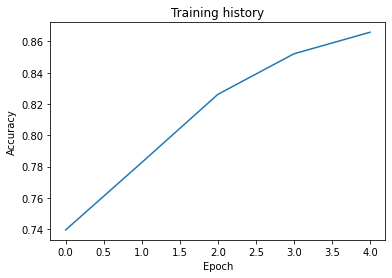

In [20]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
#plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend()
#plt.ylim([0, 1]);

In [21]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

0.8253968253968255

In [22]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      tweets = d["tweets"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(tweets)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [23]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

In [25]:
class_name = ['Hope_speech','Non_hope_speech','not-Malayalam']

In [26]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0, digits=4))

                 precision    recall  f1-score   support

    Hope_speech     0.6180    0.5670    0.5914       194
Non_hope_speech     0.8783    0.8930    0.8856       776
  not-Malayalam     0.7788    0.8020    0.7902       101

       accuracy                         0.8254      1071
      macro avg     0.7584    0.7540    0.7558      1071
   weighted avg     0.8218    0.8254    0.8233      1071



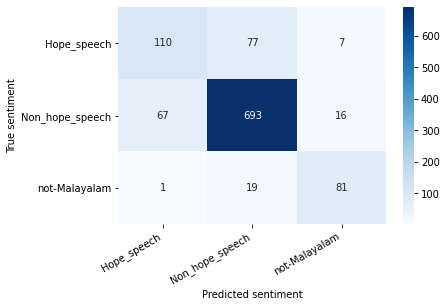

In [27]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)